In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

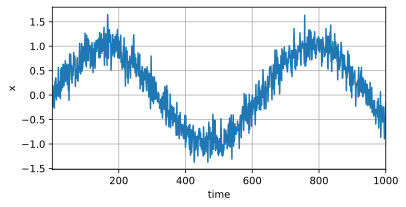

In [7]:
T=1000
time=torch.arange(1,T+1,dtype=torch.float32)
x=torch.sin(0.01*time)+torch.normal(0,0.2,(T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [8]:
tau=4
features=torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i]=x[i:T-tau+i]
labels=x[tau:].reshape((-1,1))
batch_size,n_train=16,600

train_iter=d2l.load_array((features[:n_train],labels[:n_train]),batch_size,is_train=True)

In [9]:
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
def get_net():
    net=nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )
    net.apply(init_weight)
    return net

loss=nn.MSELoss(reduction='none')

In [12]:
def train(net,train_iter,loss,epochs,lr):
    trainer=torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
            f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        
net=get_net()
train(net,train_iter,loss,1000,0.01)


epoch 1, loss: 0.062976
epoch 2, loss: 0.057048
epoch 3, loss: 0.055002
epoch 4, loss: 0.054434
epoch 5, loss: 0.054637
epoch 6, loss: 0.059976
epoch 7, loss: 0.053913
epoch 8, loss: 0.055638
epoch 9, loss: 0.055467
epoch 10, loss: 0.056307
epoch 11, loss: 0.054278
epoch 12, loss: 0.056364
epoch 13, loss: 0.054201
epoch 14, loss: 0.054076
epoch 15, loss: 0.054961
epoch 16, loss: 0.058794
epoch 17, loss: 0.055380
epoch 18, loss: 0.053379
epoch 19, loss: 0.053304
epoch 20, loss: 0.053637
epoch 21, loss: 0.053962
epoch 22, loss: 0.054911
epoch 23, loss: 0.054785
epoch 24, loss: 0.061041
epoch 25, loss: 0.059204
epoch 26, loss: 0.054420
epoch 27, loss: 0.054651
epoch 28, loss: 0.053694
epoch 29, loss: 0.053668
epoch 30, loss: 0.057042
epoch 31, loss: 0.055948
epoch 32, loss: 0.055292
epoch 33, loss: 0.054878
epoch 34, loss: 0.055928
epoch 35, loss: 0.054013
epoch 36, loss: 0.057288
epoch 37, loss: 0.053547
epoch 38, loss: 0.054439
epoch 39, loss: 0.056645
epoch 40, loss: 0.053658
epoch 41,

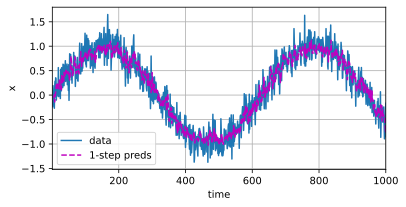

In [13]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
            'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

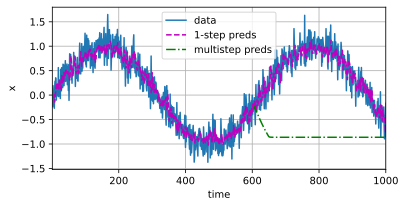

In [14]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))
    
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

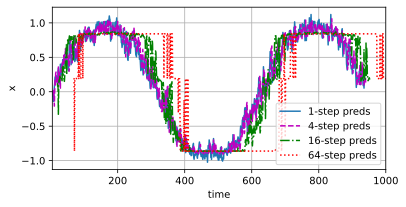

In [15]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))